---

In [1]:
# Python script was updated on 2024/02/15 by Jakob M. Helton.
# Please contact jakobhelton@arizona.edu with any questions or comments!

---

# Importing necessary modules and defining global variables...

---

In [2]:
# import necessary miscellaneous modules

import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [3]:
# imports necessary science modules

import fsps
import sedpy
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import prospect as prosp
import corner

from astropy.cosmology import FlatLambdaCDM

from prospect.io import read_results as reader
from prospect.io import write_results as writer
from prospect.fitting import fit_model, lnprobfn
from prospect.plotting.corner import quantile
from prospect.plotting.utils import sample_posterior
from prospect.models import priors, transforms, SedModel, SpecModel, LineSpecModel
from prospect.models.templates import adjust_continuity_agebins, adjust_dirichlet_agebins, describe, TemplateLibrary
from prospect.sources import CSPSpecBasis, FastStepBasis

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, MultipleLocator
matplotlib.rcParams['text.usetex'] = True

In [4]:
# imports necessary science modules related to emulator

sys.path.append(os.path.join(os.getcwd(), '', 'MathewsEtAl2023/src'))
from models import *
from obs import *
from sps import *
from utils import *

In [ ]:
# defines standard Planck18 cosmology

cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Tcmb0=2.726)

---

# Defining helper functions for the Prospector fitting...

---

In [5]:
# defines and builds model based on the methodology of Tacchella 2022c
# parametric SFH with simple delayed-tau prior

def build_model_DelayedTauSFH(z=None, zerr=None, zmin=0.0, zmax=20.0, imf_type='Chabrier', 
    lyman_alpha=True, escape_fraction=False):

    # initialize model_params dictionary

    model_params = {}
    model_params.update(TemplateLibrary['igm'])
    model_params.update(TemplateLibrary['nebular'])
    model_params.update(TemplateLibrary['parametric_sfh'])

    # change redshift in model_params dictionary

    if zerr is not None:

        model_params['zred']['isfree'] = True
        model_params['zred']['prior'] = priors.ClippedNormal(mean=z, sigma=zerr, mini=zmin, maxi=zmax)

    else:

        model_params['zred']['isfree'] = False
        model_params['zred']['init'] = z

    # change parameters in model_params dictionary
    
    if imf_type == 'Dave': model_params['imf_type']['init'] = 4
    elif imf_type == 'Kroupa': model_params['imf_type']['init'] = 2
    elif imf_type == 'Salpeter': model_params['imf_type']['init'] = 0
    elif imf_type == 'Chabrier': model_params['imf_type']['init'] = 1
    elif imf_type == 'vanDokkum': model_params['imf_type']['init'] = 3
    else: raise ValueError('IMF type is invalid.')
        
    model_params['imf_lower_limit'] = {
        'name': 'imf_lower_limit', 'N': 1, 'isfree': False, 'init': 0.08, 'units': 'type', 
    }
    model_params['imf_upper_limit'] = {
        'name': 'imf_upper_limit', 'N': 1, 'isfree': False, 'init': 120.0, 'units': 'type', 
    }

    model_params['dust_type']['init'] = 4 # attenuation curve from Kriek & Conroy (2013)
    model_params['sfh']['init'] = 4

    model_params['tau']['isfree'] = True
    model_params['mass']['isfree'] = True
    model_params['logzsol']['isfree'] = True
    model_params['gas_logz']['isfree'] = True
    model_params['gas_logu']['isfree'] = True
    model_params['igm_factor']['isfree'] = True

    # change parameter inits in model_params dictionary

    model_params['tau']['init'] = 1.0
    model_params['mass']['init'] = 1e+9
    model_params['logzsol']['init'] = 0.0
    model_params['gas_logz']['init'] = 0.0
    model_params['gas_logu']['init'] = -2.0
    model_params['igm_factor']['init'] = 1.0
    model_params['dust2']['init'] = 0.3

    # change parameter priors in model_params dictionary

    model_params['tau']['prior'] = priors.LogUniform(mini=0.1, maxi=30.0)
    model_params['mass']['prior'] = priors.LogUniform(mini=1e+5, maxi=1e+12)
    model_params['logzsol']['prior'] = priors.TopHat(mini=-2.0, maxi=0.19)
    model_params['gas_logz']['prior'] = priors.TopHat(mini=-2.0, maxi=0.50)
    model_params['gas_logu']['prior'] = priors.TopHat(mini=-4.0, maxi=-1.0)
    model_params['igm_factor']['prior'] = priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0)
    model_params['dust2']['prior'] = priors.ClippedNormal(mean=0.0, sigma=0.5, mini=0.0, maxi=4.0)

    # creates new parameters in model_params dictionary

    model_params['dust1'] = {
        'N': 1, 'isfree': False, 'init': 0.0, 
        'prior': None, 'depends_on': transforms.dustratio_to_dust1, 
    }
    model_params['dust_ratio'] = {
        'N': 1, 'isfree': True, 'init': 1.0, 
        'prior': priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0), 
    }
    model_params['dust_index'] = {
        'N': 1, 'isfree': True, 'init': 0.0, 
        'prior': priors.TopHat(mini=-1.0, maxi=+0.4), 
    }
    
    if escape_fraction: 
        
        model_params['frac_obrun'] = {
            'N': 1, 'isfree': True, 'init': 0.0, 
            'prior': priors.ClippedNormal(mean=0.0, sigma=0.5, mini=0.0, maxi=1.0), 
        }
    
    # removes Lyman-alpha line from the fitting
    
    if not lyman_alpha: 
        
        model_params['elines_to_ignore'] = {'N': 1, 'isfree': False, 'init': ['Ly alpha 1216']}

    # initialize the Prospector model

    model = SpecModel(model_params)

    # returns the Prospector model

    return model

In [6]:
# defines and builds model based on the methodology of Tacchella 2022c
# parametric SFH with simple constant prior

def build_model_ConstantSFH(z=None, zerr=None, zmin=0.0, zmax=20.0, imf_type='Chabrier', 
    lyman_alpha=True, escape_fraction=False):

    # initialize model_params dictionary

    model_params = {}
    model_params.update(TemplateLibrary['igm'])
    model_params.update(TemplateLibrary['nebular'])
    model_params.update(TemplateLibrary['parametric_sfh'])

    # change redshift in model_params dictionary

    if zerr is not None: 

        model_params['zred']['isfree'] = True
        model_params['zred']['prior'] = priors.ClippedNormal(mean=z, sigma=zerr, mini=zmin, maxi=zmax)

    else:

        model_params['zred']['isfree'] = False
        model_params['zred']['init'] = z

    # change parameters in model_params dictionary
    
    if imf_type == 'Dave': model_params['imf_type']['init'] = 4
    elif imf_type == 'Kroupa': model_params['imf_type']['init'] = 2
    elif imf_type == 'Salpeter': model_params['imf_type']['init'] = 0
    elif imf_type == 'Chabrier': model_params['imf_type']['init'] = 1
    elif imf_type == 'vanDokkum': model_params['imf_type']['init'] = 3
    else: raise ValueError('IMF type is invalid.')
        
    model_params['imf_lower_limit'] = {
        'name': 'imf_lower_limit', 'N': 1, 'isfree': False, 'init': 0.08, 'units': 'type', 
    }
    model_params['imf_upper_limit'] = {
        'name': 'imf_upper_limit', 'N': 1, 'isfree': False, 'init': 120.0, 'units': 'type', 
    }

    model_params['dust_type']['init'] = 4 # attenuation curve from Kriek & Conroy (2013)
    model_params['sfh']['init'] = 4

    model_params['mass']['isfree'] = True
    model_params['logzsol']['isfree'] = True
    model_params['gas_logz']['isfree'] = True
    model_params['gas_logu']['isfree'] = True
    model_params['igm_factor']['isfree'] = True

    # change parameter inits in model_params dictionary

    model_params['mass']['init'] = 1e+9
    model_params['logzsol']['init'] = 0.0
    model_params['gas_logz']['init'] = 0.0
    model_params['gas_logu']['init'] = -2.0
    model_params['igm_factor']['init'] = 1.0
    model_params['dust2']['init'] = 0.3

    # change parameter priors in model_params dictionary

    model_params['mass']['prior'] = priors.LogUniform(mini=1e+5, maxi=1e+12)
    model_params['logzsol']['prior'] = priors.TopHat(mini=-2.0, maxi=0.19)
    model_params['gas_logz']['prior'] = priors.TopHat(mini=-2.0, maxi=0.50)
    model_params['gas_logu']['prior'] = priors.TopHat(mini=-4.0, maxi=-1.0)
    model_params['igm_factor']['prior'] = priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0)
    model_params['dust2']['prior'] = priors.ClippedNormal(mean=0.3, sigma=1.0, mini=0.0, maxi=4.0)

    # creates new parameters in model_params dictionary

    model_params['dust1'] = {
        'N': 1, 'isfree': False, 'init': 0.0, 
        'prior': None, 'depends_on': transforms.dustratio_to_dust1, 
    }
    model_params['dust_ratio'] = {
        'N': 1, 'isfree': True, 'init': 1.0, 
        'prior': priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0), 
    }
    model_params['dust_index'] = {
        'N': 1, 'isfree': True, 'init': 0.0, 
        'prior': priors.TopHat(mini=-1.0, maxi=+0.4), 
    }
    
    if escape_fraction: 
        
        model_params['frac_obrun'] = {
            'N': 1, 'isfree': True, 'init': 0.0, 
            'prior': priors.ClippedNormal(mean=0.0, sigma=0.5, mini=0.0, maxi=1.0), 
        }

    # adjust SFH parameters to only include the constant component

    model_params['tau'] = {
        'N': 1, 'isfree': False, 'init': 1.0, 'units': 'Gyr^{-1}', 
    }
    model_params['const'] = {
        'N': 1, 'isfree': False, 'init': 1.0, 'units': 'fraction of mass in the constant component', 
    }
    model_params['tage'] = {
        'N': 1, 'isfree': False, 'init': 1e-2, 'units': 'Gyr', 
        'depends_on': transforms.tage_from_tuniv, 
    }
    model_params['tage_tuniv'] = {
        'N': 1, 'isfree': True, 'init': 1e-2/cosmo.age(z).value, 'units': 'fraction of age of the Universe', 
        'prior': priors.LogUniform(mini=1e-3/cosmo.age(z).value, maxi=1.0), 
    }
    
    # removes Lyman-alpha line from the fitting
    
    if not lyman_alpha: 
        
        model_params['elines_to_ignore'] = {'N': 1, 'isfree': False, 'init': ['Ly alpha 1216']}

    # initialize the Prospector model

    model = SpecModel(model_params)

    # returns the Prospector model

    return model

In [7]:
# defines and builds model based on the methodology of Tacchella 2022c
# non-parameteric SFH with simple continuity prior
# scale == 1.0 is bursty continuity
# scale == 0.3 is continuity

def build_model_ContinuitySFH(z=None, zerr=None, nbins=6, zmin=0.0, zmax=20.0, zform=20.0, scale=0.3, 
    imf_type='Chabrier', lyman_alpha=True, escape_fraction=False):

    # initialize model_params dictionary

    model_params = {}
    model_params.update(TemplateLibrary['igm'])
    model_params.update(TemplateLibrary['nebular'])
    model_params.update(TemplateLibrary['continuity_sfh'])

    # change redshift in model_params dictionary

    if zerr is not None:

        model_params['zred']['isfree'] = True
        model_params['zred']['prior'] = priors.ClippedNormal(mean=z, sigma=zerr, mini=zmin, maxi=zmax)

    else:

        model_params['zred']['isfree'] = False
        model_params['zred']['init'] = z

    # change parameters in model_params dictionary
    
    if imf_type == 'Dave': model_params['imf_type']['init'] = 4
    elif imf_type == 'Kroupa': model_params['imf_type']['init'] = 2
    elif imf_type == 'Salpeter': model_params['imf_type']['init'] = 0
    elif imf_type == 'Chabrier': model_params['imf_type']['init'] = 1
    elif imf_type == 'vanDokkum': model_params['imf_type']['init'] = 3
    else: raise ValueError('IMF type is invalid.')
        
    model_params['imf_lower_limit'] = {
        'name': 'imf_lower_limit', 'N': 1, 'isfree': False, 'init': 0.08, 'units': 'type', 
    }
    model_params['imf_upper_limit'] = {
        'name': 'imf_upper_limit', 'N': 1, 'isfree': False, 'init': 120.0, 'units': 'type', 
    }

    model_params['dust_type']['init'] = 4 # attenuation curve from Kriek & Conroy (2013)
    model_params['sfh']['init'] = 3
    
    model_params['logmass']['isfree'] = True
    model_params['logzsol']['isfree'] = True
    model_params['gas_logz']['isfree'] = True
    model_params['gas_logu']['isfree'] = True
    model_params['igm_factor']['isfree'] = True

    # change parameter inits in model_params dictionary

    model_params['logmass']['init'] = 9.0
    model_params['logzsol']['init'] = 0.0
    model_params['gas_logz']['init'] = 0.0
    model_params['gas_logu']['init'] = -2.0
    model_params['igm_factor']['init'] = 1.0
    model_params['dust2']['init'] = 0.3

    # change parameter priors in model_params dictionary

    model_params['logmass']['prior'] = priors.TopHat(mini=6.0, maxi=12.0)
    model_params['logzsol']['prior'] = priors.TopHat(mini=-2.0, maxi=0.19)
    model_params['gas_logz']['prior'] = priors.TopHat(mini=-2.0, maxi=0.50)
    model_params['gas_logu']['prior'] = priors.TopHat(mini=-4.0, maxi=-1.0)
    model_params['igm_factor']['prior'] = priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0)
    model_params['dust2']['prior'] = priors.ClippedNormal(mean=0.3, sigma=1.0, mini=0.0, maxi=4.0)

    # creates new parameters in model_params dictionary

    model_params['mass'] = {
        'N': 1, 'isfree': False, 'init': 1e+9, 
        'prior': None, 'depends_on': transforms.logsfr_ratios_to_masses, 
    }
    
    model_params['dust1'] = {
        'N': 1, 'isfree': False, 'init': 0.0, 
        'prior': None, 'depends_on': transforms.dustratio_to_dust1, 
    }
    model_params['dust_ratio'] = {
        'N': 1, 'isfree': True, 'init': 1.0, 
        'prior': priors.ClippedNormal(mean=1.0, sigma=0.3, mini=0.0, maxi=2.0), 
    }
    model_params['dust_index'] = {
        'N': 1, 'isfree': True, 'init': 0.0, 
        'prior': priors.TopHat(mini=-1.0, maxi=+0.4), 
    }
    
    if escape_fraction: 
        
        model_params['frac_obrun'] = {
            'N': 1, 'isfree': True, 'init': 0.0, 
            'prior': priors.ClippedNormal(mean=0.0, sigma=0.5, mini=0.0, maxi=1.0), 
        }

    # adjust age bins for non-parameteric SFH

    tuniv = cosmo.age(z).value - cosmo.age(zform).value
    agebin1, agebin2, agebin3 = np.log10(3e+6), np.log10(1e+7), np.log10(3e+7)
    model_params = adjust_agebins(model_params, scale=scale, tuniv=tuniv, nbins=nbins, 
        agebin1=agebin1, agebin2=agebin2, agebin3=agebin3)
    
    # removes Lyman-alpha line from the fitting
    
    if not lyman_alpha: 
        
        model_params['elines_to_ignore'] = {'N': 1, 'isfree': False, 'init': ['Ly alpha 1216']}

    # initialize the Prospector model

    model = SedModel(model_params)

    # returns the Prospector model

    return model

In [8]:
# defines function for adjusting the non-parametric agebins

def adjust_agebins(model_params, scale, tuniv, nbins=6, 
    agebin1=np.log10(3e+6), agebin2=np.log10(1e+7), agebin3=np.log10(3e+7)):

    # defines age bins using the given parameters

    if nbins < 4: raise Exception('Number of bins must be greater than four.')

    if agebin2 == None: agelims = ([0] + np.linspace(agebin1, np.log10(1e+9*tuniv), nbins - 1).tolist())
    elif agebin3 == None: agelims = ([0, agebin1] + np.linspace(agebin2, np.log10(1e+9*tuniv), nbins - 2).tolist())
    else: agelims = ([0, agebin1, agebin2] + np.linspace(agebin3, np.log10(1e+9*tuniv), nbins - 3).tolist())

    agebins = np.array([agelims[:-1], agelims[1:]])

    mean = np.zeros(nbins - 1)
    scale = scale*np.ones_like(mean)
    degrees_of_freedom = 2.0*np.ones_like(mean)
    prior = priors.StudentT(mean=mean, scale=scale, df=degrees_of_freedom)

    model_params['mass']['N'] = nbins
    model_params['agebins']['N'] = nbins
    model_params['agebins']['init'] = agebins.T
    model_params['logsfr_ratios']['N'] = nbins - 1
    model_params['logsfr_ratios']['init'] = mean
    model_params['logsfr_ratios']['prior'] = prior

    # returns the model parameters

    return model_params

In [9]:
# defines and builds stellar population synthesis object for parametric SFHs

def get_stellarPopulationSynthesis_Parametric():

    # returns the stellar population synthesis object

    return CSPSpecBasis()

In [10]:
# defines and builds stellar population synthesis object for non-parametric SFHs

def get_stellarPopulationSynthesis_NonParametric():

    # returns the stellar population synthesis object

    return FastStepBasis()

In [54]:
# defines function for initializing a pandas dataframe for the Prospector results

def initialize_df(theta_labels, nbins=None, zred=False):
    
    # create list of columns names, to initialize the pandas dataframe

    columns = ['ID']
    
    if zred: 

        columns.append('zred_p16')
        columns.append('zred_p50')
        columns.append('zred_p84')

    columns.append('logmass_stellar_p16')
    columns.append('logmass_stellar_p50')
    columns.append('logmass_stellar_p84')

    columns.append('logage_stellar_p16')
    columns.append('logage_stellar_p50')
    columns.append('logage_stellar_p84')

    columns.append('logssfr_p16')
    columns.append('logssfr_p50')
    columns.append('logssfr_p84')

    columns.append('sfr_p16')
    columns.append('sfr_p50')
    columns.append('sfr_p84')

    for label in theta_labels: 
        
        if label == 'zred': continue

        columns.append(f'{label}_p16')
        columns.append(f'{label}_p50')
        columns.append(f'{label}_p84')

    if nbins is not None:

        for n in range(nbins + 1): 

            columns.append(f'logagebin{n}')

    return pd.DataFrame(columns=columns)

In [29]:
# defines function for inserting a row filled with NaNs into a pandas dataframe

def insert_nan_row_df(df, ID):
    
    # iterates through columns to fill with NaNs and insert into dataframe
    
    dictionary = {}
    
    for column in df.columns: 
        
        if column == 'ID': dictionary[column] = ID
        else: dictionary[column] = np.nan

    temp_df = pd.DataFrame(dictionary, index=[0])
    
    return pd.concat([temp_df, df], ignore_index=True)

---

# Defining helper functions for the Prospector-Beta fitting...

---

In [11]:
# defines and builds model based on the methodology of Wang et al. (2023)

def build_ProspectorBetaModel():

    # initializes and returns the assumed Prospector model

    model_params = {} 
    model_params.update(TemplateLibrary['beta'])
    return SedModel(model_params)

In [12]:
# defines and builds model for the FSPS objects, for model predictions

def build_modelFSPS(obs=None, sps=None, nbins_sfh=7, **extras):
    
    fit_order = [
        'massmet', 'logsfr_ratios', 'dust2', 'dust_index', 'dust1_fraction',
        'log_fagn', 'log_agn_tau', 'gas_logz', 'zred', 'duste_qpah', 'duste_umin', 'log_duste_gamma', 
    ]

    model_params = {}

    model_params['zred'] = {
        'N': 1, 'isfree': True, 'init': obs['zred'], 'prior': FastUniform(a=1e-3, b=12.0), 
    }
    
    model_params['add_igm_absorption'] = {'N': 1, 'isfree': False, 'init': 1}
    
    model_params['add_agb_dust_model'] = {'N': 1, 'isfree': False, 'init': True}
    
    model_params['pmetals'] = {'N': 1, 'isfree': False, 'init': -99}

    model_params['logmass'] = {
        'N': 1, 'isfree': False, 'depends_on': massmet_to_logmass, 
        'init': 10.0, 'units': 'Msun', 'prior': FastUniform(a=7.0, b=12.5), 
    }

    model_params['logzsol'] = {
        'N': 1, 'isfree': False, 'depends_on': massmet_to_logzsol,
        'init': -0.5, 'units': r'$\log (Z/Z_\odot)$', 'prior': FastUniform(a=-1.98, b=0.19), 
    }

    model_params['massmet'] = {
        'N': 2, 'isfree': True, 'init': np.array([10, -0.5]), 'prior': FastMassMet(a=6.0, b=12.5), 
    }

    model_params['sfh'] = {'N': 1, 'isfree': False, 'init': 0}
    
    model_params['mass'] = {'N': 1, 'isfree': False, 'init': 1.0, 'depends_on': logmass_to_masses}
    
    model_params['agebins'] = {'N': 1, 'isfree': False, 'init': [], 'depends_on': zred_to_agebins}
    
    model_params['logsfr_ratios'] = {
        'N': 6, 'isfree': True, 'init': np.zeros(nbins_sfh - 1),
        'prior': FastTruncatedEvenStudentTFreeDeg2(hw=5.0*np.ones(6), sig=0.3*np.ones(6)), 
    }
    
    model_params['imf_type'] = {'N': 1, 'isfree': False, 'init': 1}

    model_params['dust_type'] = {'N': 1, 'isfree': False, 'init': 4}
    
    model_params['dust1'] = {'N': 1, 'isfree': False, 'init': 1.0, 'depends_on': to_dust1}
    
    model_params['dust1_fraction'] = {
        'N': 1, 'isfree': True, 'init': 1.0, 
        'prior': FastTruncatedNormal(a=0.0, b=2.0, mu=1.0, sig=0.3), 
    }

    model_params['dust2'] = {
        'N': 1, 'isfree': True, 'init': 0.0, 'units': '', 
        'prior': FastTruncatedNormal(a=0.0, b=4.0, mu=0.3, sig=1.0), 
    }

    model_params['dust_index'] = {
        'N': 1, 'isfree': True, 'init': 0.7, 'units': '', 'prior': FastUniform(a=-1.2, b=0.4), 
    }
    
    model_params['dust1_index'] = {'N': 1, 'isfree': False, 'init': -1.0}
    
    model_params['dust_tesc'] = {'N': 1, 'isfree': False, 'init': 7.0}
    
    model_params['add_dust_emission'] = {'N': 1, 'isfree': False, 'init': 1}
    
    model_params['duste_qpah'] = {
        'N':1, 'isfree':True, 'init': 2.0, 'prior': FastTruncatedNormal(a=0.0, b=7.0, mu=2.0, sig=2.0), 
    }

    model_params['duste_umin'] = {
        'N':1, 'isfree':True, 'init': 1.0, 'prior': FastTruncatedNormal(a=0.1, b=25.0, mu=1.0, sig=10.0), 
    }
    
    model_params['duste_gamma'] = {'N': 1, 'isfree': False, 'init': 0.01, 'depends_on': to_duste_gamma}

    model_params['log_duste_gamma'] = {
        'N':1, 'isfree':True, 'init': -2.0, 'prior': FastTruncatedNormal(a=-4.0, b=0.0, mu=-2.0, sig=1.0), 
    }

    model_params['add_neb_emission'] = {'N': 1, 'isfree': False, 'init': True}
    
    model_params['add_neb_continuum'] = {'N': 1, 'isfree': False, 'init': True}
    
    model_params['nebemlineinspec'] = {'N': 1, 'isfree': False, 'init': True}
    
    model_params['gas_logz'] = {
        'N': 1, 'isfree': True, 'init': -0.5,
        'units': r'log Z/Z_\odot', 'prior': FastUniform(a=-2.0, b=0.5), 
    }
    
    model_params['gas_logu'] = {'N': 1, 'isfree': False, 'init': -1.0}

    model_params['add_agn_dust'] = {'N': 1, 'isfree': False, 'init': True}
    
    model_params['fagn'] = {'N': 1, 'isfree': False, 'init': 0.01, 'depends_on': to_fagn}
    
    model_params['agn_tau'] = {'N': 1, 'isfree': False, 'init': 10.0, 'depends_on': to_agn_tau}
    
    model_params['log_fagn'] = {'N': 1, 'isfree': True,
                                'init': -7.0e-5,
                                'prior': FastUniform(a=-5.0, b=np.log10(3.0))}

    model_params['log_agn_tau'] = {'N': 1, 'isfree': True,
                                   'init': np.log10(20.0),
                                   'prior': FastUniform(a=np.log10(5.0), b=np.log10(150.0))}
    
    model_params['phot_jitter'] = {'N': 1, 'isfree': False, 'init': 0.0}
    
    model_params['sigma_smooth'] = {'N': 1, 'isfree': False, 'init': 0.0}

    model_params['peraa'] = {'N': 1, 'isfree': False, 'init': False}

    model_params['mass_units'] = {'N': 1, 'isfree': False, 'init': 'mformed'}

    agebins = zred_to_agebins(zred = [model_params['zred']['init']], nbins_sfh = nbins_sfh)
    
    model_params['agebins']['N'] = 7
    model_params['agebins']['init'] = agebins
    
    model_params['mass']['N'] = nbins_sfh
    
    model_params['logsfr_ratios']['N'] = nbins_sfh - 1
    model_params['logsfr_ratios']['init'] = np.zeros(nbins_sfh - 1)
    
    extra = [k for k in model_params.keys() if k not in fit_order]
    
    fit_order = fit_order + list(extra)
    
    new_model_params = [model_params[par] for par in fit_order]
    
    for (i, m) in enumerate(new_model_params): new_model_params[i]['name'] = fit_order[i]
        
    model_params = new_model_params
    
    model = SedModel(model_params, obs=obs, sps=sps)

    model.predict = types.MethodType(_predict, model)

    return model

In [13]:
# defines and builds custom prediction function for the emulated FSPS objects

def _predict(self, theta, obs=None, sps=None, **extras):
    
    s, p, x = self.sed(theta, obs, sps=sps, **extras)
    
    self._speccal = self.spec_calibration(obs=obs, **extras)
    
    if obs.get('logify_spectrum', False): s = np.log(s) + np.log(self._speccal)
    else: s *= self._speccal
        
    return s, xm(ux(p)), x

In [14]:
# defines and builds run parameters dictionary

def build_run_params(objid, nbins=7, nested_target_n_effective=int(2e+5)):
    
    # initializes dictionary
    
    run_params = {
        # Object Selection
        'objid': objid,
        # Emulator Selection
        'emulfp': os.path.join(os.getcwd(), '', 'MathewsEtAl2023/data', 'parrot_v4_obsphot_512n_5l_24s_00z24.npy'),
        # Dynesty Hyperparameter Initialization
        'nested_maxbatch': None, # maximum number of dynamic patches
        'nested_sample': 'rwalk', # sampling method
        'nested_bound': 'multi', # bounding method
        'nested_walks': int(1e+1), # MC walks
        'nested_nlive_batch': int(1e+2), # size of live point "batches"
        'nested_nlive_init': int(1e+3), # number of initial live points
        'nested_weight_kwargs': {'pfrac': 1.0}, # weight posterior over evidence by 100%
        'nested_target_n_effective': nested_target_n_effective, # target effective sample size
        'nested_dlogz_init': 0.02,
        # FSPS Hyperparameter Initialization
        'zcontinuous': 2,
        'compute_vega_mags': False,
        'initial_disp': 0.1,
        'interp_type': 'logarithmic',
        'nbins_sfh': nbins,
        'df': 2,
    }
    
    # returns dictionary
    
    return run_params

---

# Defining set of observations...

---

In [15]:
# defines hyperparameter for a maximum allowed signal-to-noise ratio of 20
# aka defines hyperparameter for a noise floor of 5%

maximum_SNR = 20.0

In [16]:
# These data are taken from Tacchella et al. (2023a) for GN-z11
# This is currently one of the highest redshift objects with spectroscopic confirmation at zSpec = 10.60

# https://ui.adsabs.harvard.edu/abs/2023ApJ...952...74T/abstract
# DOI: 10.3847/1538-4357/acdbc6
# DOI: 10.48550/arXiv.2302.07234

# JADES Imaging of GN-z11: Revealing the Morphology and Environment of a Luminous Galaxy 430 Myr after the Big Bang

Name_GN_z11 = 'GN-z11'

Data_GN_z11 = np.array([
    [sedpy.observate.Filter(kname='jwst_f090w'),   -3.5, +1.2], 
    [sedpy.observate.Filter(kname='jwst_f115w'),   -2.6, +1.1], 
    [sedpy.observate.Filter(kname='jwst_f150w'), +106.5, +1.9], 
    [sedpy.observate.Filter(kname='jwst_f200w'), +143.4, +1.8], 
    [sedpy.observate.Filter(kname='jwst_f277w'), +109.8, +2.0], 
    [sedpy.observate.Filter(kname='jwst_f335m'), +112.8, +4.0], 
    [sedpy.observate.Filter(kname='jwst_f356w'), +108.6, +1.8], 
    [sedpy.observate.Filter(kname='jwst_f410m'), +113.7, +2.9], 
    [sedpy.observate.Filter(kname='jwst_f444w'), +122.9, +2.7], 
])

Data_GN_z11[:, 2] = np.amax([Data_GN_z11[:, 1]/maximum_SNR, Data_GN_z11[:, 2]], axis=0)

observed_data = {}
observed_data['mask'] = None
observed_data['wavelength'] = None
observed_data['filters'] = np.array((Data_GN_z11[:, 0]).tolist())
observed_data['maggies'] = np.array((1e-9*Data_GN_z11[:, 1]/3631.0).tolist())
observed_data['maggies_unc'] = np.array((1e-9*Data_GN_z11[:, 2]/3631.0).tolist())
observed_data['wavelengths_phot'] = np.array([f.wave_effective for f in observed_data['filters']])
observed_data['zred'] = 10.60

observations_GN_z11 = prosp.utils.obsutils.fix_obs(observed_data); observations_GN_z11

{'mask': None,
 'wavelength': None,
 'filters': array([<class 'sedpy.observate.Filter'>(jwst_f090w),
        <class 'sedpy.observate.Filter'>(jwst_f115w),
        <class 'sedpy.observate.Filter'>(jwst_f150w),
        <class 'sedpy.observate.Filter'>(jwst_f200w),
        <class 'sedpy.observate.Filter'>(jwst_f277w),
        <class 'sedpy.observate.Filter'>(jwst_f335m),
        <class 'sedpy.observate.Filter'>(jwst_f356w),
        <class 'sedpy.observate.Filter'>(jwst_f410m),
        <class 'sedpy.observate.Filter'>(jwst_f444w)], dtype=object),
 'maggies': array([-9.63921785e-13, -7.16056183e-13,  2.93307629e-11,  3.94932525e-11,
         3.02396034e-11,  3.10658221e-11,  2.99091159e-11,  3.13136877e-11,
         3.38474250e-11]),
 'maggies_unc': array([3.30487469e-13, 3.02946847e-13, 1.46653814e-12, 1.97466263e-12,
        1.51198017e-12, 1.55329110e-12, 1.49545580e-12, 1.56568438e-12,
        1.69237125e-12]),
 'wavelengths_phot': array([ 8980.67004542, 11487.92207826, 14942.71221532, 

In [59]:
# These data are taken from Robertson et al. (2023a) for JADES-GS-z13-0
# This is currently the highest redshift objects with spectroscopic confirmation at zSpec = 13.20

# https://ui.adsabs.harvard.edu/abs/2023NatAs...7..611R/abstract
# DOI: 10.1038/s41550-023-01921-1
# DOI: 10.48550/arXiv.2212.04480

# Identification and properties of intense star-forming galaxies at redshifts z > 10

Name_JADES_GS_z13_0 = 'JADES-GS-z13-0'

Data_JADES_GS_z13_0 = np.array([
    [sedpy.observate.Filter(kname='jwst_f090w'), +0.36, +0.34], 
    [sedpy.observate.Filter(kname='jwst_f115w'), +0.28, +0.25], 
    [sedpy.observate.Filter(kname='jwst_f150w'), -0.57, +0.27], 
    [sedpy.observate.Filter(kname='jwst_f182m'), +5.11, +0.69], 
    [sedpy.observate.Filter(kname='jwst_f200w'), +6.43, +0.38], 
    [sedpy.observate.Filter(kname='jwst_f210m'), +6.87, +0.75], 
    [sedpy.observate.Filter(kname='jwst_f277w'), +6.35, +0.50], 
    [sedpy.observate.Filter(kname='jwst_f335m'), +4.91, +0.90], 
    [sedpy.observate.Filter(kname='jwst_f356w'), +5.44, +0.56], 
    [sedpy.observate.Filter(kname='jwst_f410m'), +5.47, +1.07], 
    [sedpy.observate.Filter(kname='jwst_f444w'), +5.68, +0.84], 
])

Data_JADES_GS_z13_0[:, 2] = np.amax([Data_JADES_GS_z13_0[:, 1]/maximum_SNR, Data_JADES_GS_z13_0[:, 2]], axis=0)

observed_data = {}
observed_data['mask'] = None
observed_data['wavelength'] = None
observed_data['filters'] = np.array((Data_JADES_GS_z13_0[:, 0]).tolist())
observed_data['maggies'] = np.array((1e-9*Data_JADES_GS_z13_0[:, 1]/3631.0).tolist())
observed_data['maggies_unc'] = np.array((1e-9*Data_JADES_GS_z13_0[:, 2]/3631.0).tolist())
observed_data['wavelengths_phot'] = np.array([f.wave_effective for f in observed_data['filters']])
observed_data['zred'] = 13.20

observations_JADES_GS_z13_0 = prosp.utils.obsutils.fix_obs(observed_data); observations_JADES_GS_z13_0

{'mask': None,
 'wavelength': None,
 'filters': array([<class 'sedpy.observate.Filter'>(jwst_f090w),
        <class 'sedpy.observate.Filter'>(jwst_f115w),
        <class 'sedpy.observate.Filter'>(jwst_f150w),
        <class 'sedpy.observate.Filter'>(jwst_f182m),
        <class 'sedpy.observate.Filter'>(jwst_f200w),
        <class 'sedpy.observate.Filter'>(jwst_f210m),
        <class 'sedpy.observate.Filter'>(jwst_f277w),
        <class 'sedpy.observate.Filter'>(jwst_f335m),
        <class 'sedpy.observate.Filter'>(jwst_f356w),
        <class 'sedpy.observate.Filter'>(jwst_f410m),
        <class 'sedpy.observate.Filter'>(jwst_f444w)], dtype=object),
 'maggies': array([ 9.91462407e-14,  7.71137428e-14, -1.56981548e-13,  1.40732581e-12,
         1.77086202e-12,  1.89204076e-12,  1.74882952e-12,  1.35224456e-12,
         1.49820986e-12,  1.50647205e-12,  1.56430735e-12]),
 'maggies_unc': array([9.36381162e-14, 6.88515560e-14, 7.43596805e-14, 1.90030295e-13,
        1.04654365e-13, 2.065546

---

# Running Prospector-Beta for GN-z11...

---

In [26]:
# Prospector-Beta fitting for GN-z11

# Very important pieces of information: 
# to first order, 'nested_target_n_effective' dictates the run time
# to second order, 'nested_dlogz_init' dictates the run time, at least for the initialization

# nested_target_n_effective == int(2e+5); run_time == 2600 seconds
# nested_target_n_effective == int(8e+4); run_time == 983 seconds
# nested_target_n_effective == int(4e+4); run_time == 486 seconds
# nested_target_n_effective == int(2e+4); run_time == 294 seconds
# nested_target_n_effective == int(8e+3); run_time == 176 seconds
# nested_target_n_effective == int(4e+3); run_time == 185 seconds
# nested_target_n_effective == int(2e+3); run_time == 165 seconds

# nested_target_n_effective == int(2e+5) is the largest value that I would recommend
# nested_target_n_effective == int(2e+4) is the smallest value that I would recommend

nbins = 7; nested_target_n_effective = int(2e+4)

run_params = build_run_params(Name_GN_z11, nbins=nbins, nested_target_n_effective=nested_target_n_effective)
hfile = f'/Users/JakeHelton/Downloads/tempFolder/{Name_GN_z11}_ProspectorBeta.h5'
t1 = time.time()

sps_emulator = build_sps_emulator(**run_params)
model_emulator = build_model_stitched(obs=observations_GN_z11, sps=sps_emulator, **run_params)
observations_emulator = modify_obs_stitched(obs=observations_GN_z11, model=model_emulator)
output_emulator = fit_model(observations_emulator, model_emulator, sps_emulator, **run_params)
writer.write_hdf5(hfile, run_params, model=model_emulator, obs=observations_emulator, sps=sps_emulator, 
    sampler=output_emulator['sampling'][0], optimize_result_list=output_emulator['optimization'][0], 
    tsample=output_emulator['sampling'][1], toptimize=output_emulator['optimization'][1])

t2 = time.time(); clear_output()
print(f'Prospector-Beta fitting completed for {Name_GN_z11}...')
print(f'The total time elapsed for the fitting was {t2 - t1:.1f} seconds.')

Prospector-Beta fitting completed for GN-z11...
The total time elapsed for the fitting was 296.5 seconds.


In [51]:
# Reads in the output h5 file and extracts some relevant information

stellarPopulationSynthesis = build_sps_fsps(**run_params)
model = build_modelFSPS(obs=observations_GN_z11, sps=stellarPopulationSynthesis, **run_params)
result, observations, _ = reader.results_from(hfile, dangerous=False)
theta_labels = np.array(result['theta_labels'])

# Loops through the chain to extract photometric and spectroscopic model predictions

U = sedpy.observate.Filter(kname='bessell_U')
V = sedpy.observate.Filter(kname='bessell_V')
J = sedpy.observate.Filter(kname='twomass_J')

N = int(1e+3)
model.ndim = len(theta_labels)
weights = result.get('weights', None)
agebins = model.config_dict['agebins']['init']
array_spec, array_phot, array_mfrac = [], [], []
array_U, array_V, array_J = [], [], []

for index in range(N):
    
    theta = prosp.plotting.utils.sample_posterior(result['chain'], weights=weights, nsample=1)[0]
    spec, phot, mfrac = model.predict(theta, obs=observations, sps=stellarPopulationSynthesis)
    array_spec.append(spec); array_phot.append(phot); array_mfrac.append(mfrac)
    
    temp_redshift = theta[np.where(theta_labels == 'zred')]
    temp_wavelengths = stellarPopulationSynthesis.wavelengths # *(1.0 + temp_redshift)
    temp_flux = 3631e-23*spec*(2.998e+18/np.square(temp_wavelengths))
    array_U.append(U.ab_mag(temp_wavelengths, temp_flux))
    array_V.append(V.ab_mag(temp_wavelengths, temp_flux))
    array_J.append(J.ab_mag(temp_wavelengths, temp_flux))
    
array_U = np.array(array_U)
array_V = np.array(array_V)
array_J = np.array(array_J)
    
array_spec = np.array(array_spec)
array_phot = np.array(array_phot)
array_mfrac = np.array(array_mfrac)

mfrac = np.median(array_mfrac)

In [72]:
# Calculations for inferred stellar population properties

sfr_indices = np.array([i for i, label in enumerate(theta_labels) if label[:6] == 'logsfr'])
logmass = result['chain'][:, np.where(theta_labels == 'massmet_1')[0][0]]
logsfr_ratios = result['chain'][:, sfr_indices]

N = agebins.shape[0]
ratios = np.power(10, np.clip(logsfr_ratios, -100, +100)).T
bins = (np.power(10, agebins[:, 1]) - np.power(10, agebins[:, 0]))
temp_bins = np.array([temp + bins[i - 1] for i, temp in enumerate(bins) if i > 0])
temp_bins = np.insert(temp_bins, 0, bins[0])
coeffs = [(1.0/np.prod(ratios[:i, :], axis=0))*(np.prod(bins[1:i+1])/np.prod(bins[:i])) for i in range(N)]
m1 = np.power(10, logmass)/np.array(coeffs).sum(axis=0)
masses = m1*np.array(coeffs)
sfrs = masses.T/bins.T

for index, agebin in enumerate(np.unique(agebins.flatten())): 
    
    if index == 0: 
        
        if agebin >= 7.0: 
            
            sfr_10Myr = sfrs[:, index]
            break 
            
        else: 
            
            temp_agebin = np.power(10, agebin)
            sfr_10Myr = sfrs[:, index]*(temp_agebin)/1e+7
        
        if agebin >= 8.0: 
            
            sfr_100Myr = sfrs[:, index]
            break
            
        else: 
            
            temp_agebin = np.power(10, agebin)
            sfr_100Myr = sfrs[:, index]*(temp_agebin)/1e+8
            
    else: 
        
        if agebin >= 7.0: 
            
            sfr_10Myr += sfrs[:, 0]*(np.power(10, agebin) - temp_agebin)/1e+7
            break 
            
        else: 
            
            temp_temp_agebin = temp_agebin
            temp_agebin = np.power(10, agebin)
            sfr_10Myr += sfrs[:, index]*(temp_agebin - temp_temp_agebin)/1e+7
        
        if agebin >= 8.0: 
            
            sfr_100Myr += sfrs[:, index]*(np.power(10, agebin) - temp_agebin)/1e+8
            break 
            
        else: 
            
            temp_temp_agebin = temp_agebin
            temp_agebin = np.power(10, agebin)
            sfr_100Myr += sfrs[:, index]*(temp_agebin - temp_temp_agebin)/1e+8
        

sfr = sfr_10Myr; ssfr = np.log10(sfr) - logmass

# Initializes dataframe for the Prospector results

Results = initialize_df(theta_labels, nbins=7, zred=True)

# Inputs the Prospector results into the initialized dataframe

dictionary = {}
dictionary['ID'] = Name_GN_z11

percentiles = quantile(result['chain'].T, q=[0.16, 0.50, 0.84], weights=weights)

for label, percentile in zip(theta_labels, percentiles): 

    dictionary[f'{label}_p16'] = percentile[0]
    dictionary[f'{label}_p50'] = percentile[1]
    dictionary[f'{label}_p84'] = percentile[2]

ages = 0.5*(np.power(10, agebins)[:, 1] + np.power(10, agebins)[:, 0])
mass_percentiles = quantile(masses, q=[0.16, 0.50, 0.84], weights=weights)
sfr_percentiles = quantile(sfr[np.newaxis], q=[0.16, 0.50, 0.84], weights=weights)[0]
ssfr_percentiles = quantile(ssfr[np.newaxis], q=[0.16, 0.50, 0.84], weights=weights)[0]
logmass_percentiles = quantile(logmass[np.newaxis], q=[0.16, 0.50, 0.84], weights=weights)[0]
stellar_ages = np.sum(ages*quantile(masses, q=[0.16, 0.50, 0.84], weights=weights).T, axis=1)
stellar_ages /= np.power(10, logmass_percentiles[1])

dictionary['logmass_stellar_p16'] = np.log10(mfrac*np.power(10, dictionary['massmet_1_p16']))
dictionary['logmass_stellar_p50'] = np.log10(mfrac*np.power(10, dictionary['massmet_1_p50']))
dictionary['logmass_stellar_p84'] = np.log10(mfrac*np.power(10, dictionary['massmet_1_p84']))

dictionary['logage_stellar_p16'] = np.log10(stellar_ages[0])
dictionary['logage_stellar_p50'] = np.log10(stellar_ages[1])
dictionary['logage_stellar_p84'] = np.log10(stellar_ages[2])

dictionary['logssfr_p16'] = ssfr_percentiles[0]
dictionary['logssfr_p50'] = ssfr_percentiles[1]
dictionary['logssfr_p84'] = ssfr_percentiles[2]

dictionary['sfr_p16'] = sfr_percentiles[0]
dictionary['sfr_p50'] = sfr_percentiles[1]
dictionary['sfr_p84'] = sfr_percentiles[2]

for n in range(nbins + 1): 

    dictionary[f'logagebin{n}'] = np.unique(agebins.flatten())[n]

temp_Results = pd.DataFrame(dictionary, index=[0])
Results = pd.concat([Results, temp_Results], ignore_index=True); Results

,ID,zred_p16,zred_p50,zred_p84,logmass_stellar_p16,logmass_stellar_p50,logmass_stellar_p84,logage_stellar_p16,logage_stellar_p50,logage_stellar_p84,...,log_duste_gamma_p50,log_duste_gamma_p84,logagebin0,logagebin1,logagebin2,logagebin3,logagebin4,logagebin5,logagebin6,logagebin7
0,GN-z11,10.785827,10.934268,11.114705,9.071759,9.334226,9.509877,7.645243,8.253408,8.546855,...,-1.677831,-1.024964,0.0,7.374592,7.619684,7.864776,8.109868,8.35496,8.600052,8.64581


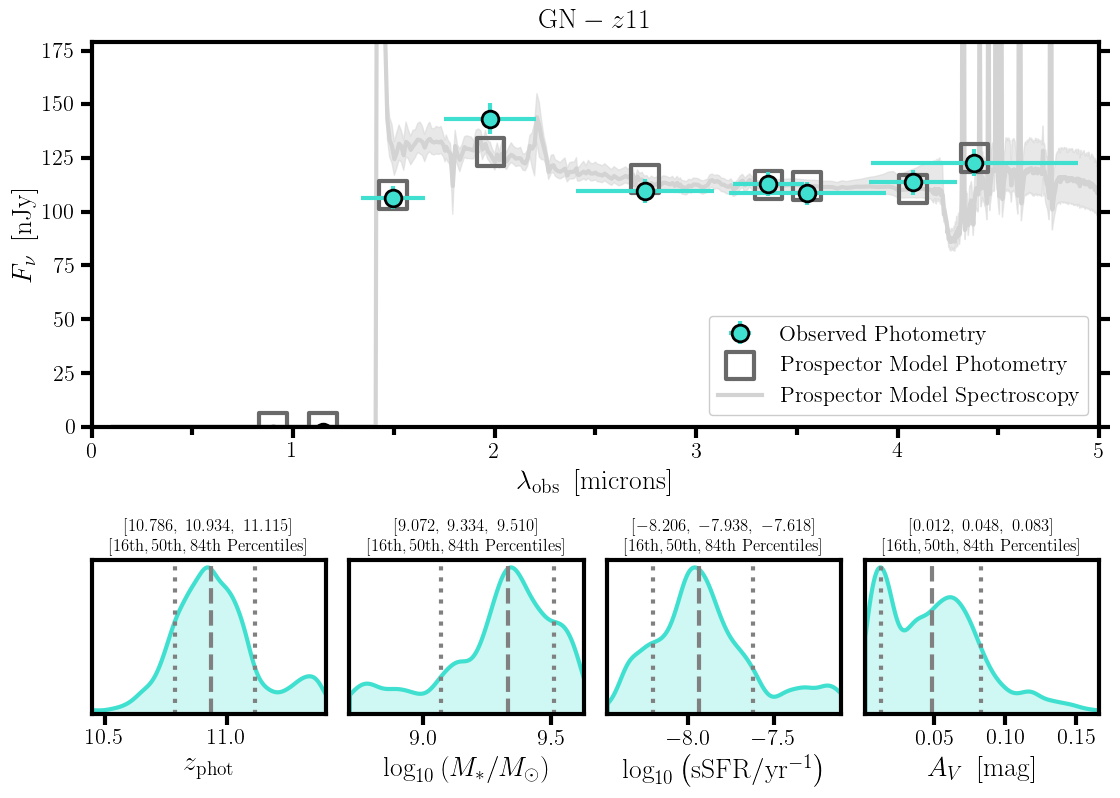

In [73]:
#

ID = r'$\mathrm{GN}-z11$'
lw = 3; mew = 2; ms_model = 20; ms_observed = 12, 
color_model_phot = 'dimgrey'; color_model_spec = 'lightgray'
fontsize_big = 20; fontsize_small = 16; min_flux = 1e+0; max_wave = 5.0; plot_type = 'liny'; show = True

observations['wavelength'] = stellarPopulationSynthesis.wavelengths*(1.0 + observations['zred'])
    
spec_p16, spec_p50, spec_p84 = 3631e+9*np.percentile(array_spec, [16, 50, 84], axis=0)
phot_p16, phot_p50, phot_p84 = 3631e+9*np.percentile(array_phot, [16, 50, 84], axis=0)

#

plt.close()
fig = plt.figure(figsize=(13, 8))
grid = matplotlib.gridspec.GridSpec(3, 4, hspace=0.5, wspace=0.1)

ax = plt.subplot(grid[0:2, :])

ax.tick_params(axis='both', which='major', direction='out', 
    bottom=True, top=False, left=True, right=True, length=8, width=lw, labelsize=fontsize_small)
ax.tick_params(axis='both', which='minor', direction='out', 
    bottom=True, top=False, left=True, right=True, length=6, width=lw, labelsize=fontsize_small)

if type(observations['filters'][0]) == str:

    f = [sedpy.observate.Filter(kname=f, directory=os.getcwd() + '/filters/') for f in observations['filters']]
    wave = observations['wavelengths_phot']

else:

    f = observations['filters']
    wave = np.array([filt.wave_effective for filt in f])

flux, yerr = 3631e+9*observations['maggies'], 3631e+9*observations['maggies_unc']
mask, wave_spec = observations['phot_mask'], observations['wavelength']
model_spec, model_flux = spec_p50, phot_p50

temp_flux1 = flux[mask]
temp_flux2 = model_flux[mask]
temp_flux3 = model_spec[np.logical_and(0.0 < wave_spec, wave_spec < 1e+4*max_wave)]

ymax = np.amax([np.amax(temp_flux1), np.amax(temp_flux2)])
ymin = np.amax([min_flux, np.amin([np.amin(temp_flux1[temp_flux1 > 0]), np.amin(temp_flux2[temp_flux2 > 0])])])

xerr = np.array([0.5e-4*filt.rectangular_width for filt in f])
ax.errorbar(1e-4*wave[mask], flux[mask], xerr=xerr[mask], yerr=yerr[mask], marker='o', 
    ms=ms_observed[0], mec='k', c='turquoise', ls='', lw=lw, mew=mew, zorder=2, 
    label=r'$\mathrm{Observed\ Photometry}$')
ax.scatter(1e-4*wave[mask], model_flux[mask], edgecolors=color_model_phot, c='None', 
    s=np.square(ms_model), marker='s', linewidths=lw, zorder=1, 
    label=r'$\mathrm{Prospector\ Model\ Photometry}$')
ax.plot(1e-4*wave_spec, model_spec, color=color_model_spec, marker='', lw=lw, zorder=0, 
    label=r'$\mathrm{Prospector\ Model\ Spectroscopy}$')
ax.fill_between(1e-4*wave_spec, spec_p16, spec_p84, color=color_model_spec, alpha=0.5, zorder=0)

x_min, x_max = 0.0, max_wave
ax.set_title(ID, fontsize=fontsize_big, pad=9)
ax.set_xlabel(fr'$\lambda_{{\mathrm{{obs}}}}\ \left[ \mathrm{{microns}} \right]$', fontsize=fontsize_big)

ax.set_ylabel(fr'$F_{{\nu}}\ \left[ \mathrm{{nJy}} \right]$', fontsize=fontsize_big)

ax.set_xlim(x_min, x_max)
ax.set_xticks(np.arange(x_min, x_max + 0.1, 1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

if plot_type == 'liny':

    ax.set_ylim(0.0, 1.25*ymax)

if plot_type == 'logy':

    ax.set_yscale('log')
    diff = 0.2*(np.log10(ymax) - np.log10(ymin))
    ax.set_ylim(ymin/10**diff, ymax*10**diff)

handles, labels = ax.get_legend_handles_labels(); ordering = [2, 0, 1]
handles, labels = [handles[i] for i in ordering], [labels[i] for i in ordering]
ax.legend(handles, labels, loc='lower right', fontsize=fontsize_small, ncol=1, framealpha=1)

#

zred = result['chain'][:, np.where(theta_labels == 'zred')[0][0]]
dust2 = result['chain'][:, np.where(theta_labels == 'dust2')[0][0]]
logfagn = result['chain'][:, np.where(theta_labels == 'log_fagn')[0][0]]
logagntau = result['chain'][:, np.where(theta_labels == 'log_agn_tau')[0][0]]
logmass = result['chain'][:, np.where(theta_labels == 'massmet_1')[0][0]]
logzsol = result['chain'][:, np.where(theta_labels == 'massmet_2')[0][0]]

axes = []
params = ['zred', 'logmass', 'ssfr', 'dust2']
labels = [
    r'$z_{\mathrm{phot}}$', 
    r'$\mathrm{log}_{10}\left( M_{\ast}/M_{\odot} \right)$', 
    r'$\mathrm{log}_{10}\left( \mathrm{sSFR}/\mathrm{yr}^{-1} \right)$', 
    r'$A_{V}\ \left[ \mathrm{mag} \right]$', 
]

for i in range(len(params)):

    if params[i] == 'zred': chain = zred
    if params[i] == 'dust2': chain = dust2
    if params[i] == 'logfagn': chain = logfagn
    if params[i] == 'logagntau': chain = logagntau
    if params[i] == 'logmass': chain = np.log10(mfrac*np.power(10, logmass))
    if params[i] == 'logzsol': chain = logzsol
    if params[i] == 'ssfr': chain = ssfr

    axes.append(plt.subplot(grid[2, i]))

    axes[-1].tick_params(axis='both', which='major', direction='out', 
        top=False, right=True, length=8, width=3, labelsize=fontsize_small)
    axes[-1].tick_params(axis='both', which='minor', direction='out', 
        top=False, right=True, length=8, width=3, labelsize=fontsize_small)

    q = [0.01, 0.16, 0.50, 0.84, 0.99]
    perc1, perc16, perc50, perc84, perc99 = quantile(chain[np.newaxis], q=q, weights=weights)[0]
    axes[-1].set_xlim(perc1, perc99)
    axes[-1].axvline(perc16, c='grey', ls=':', lw=3, zorder=1)
    axes[-1].axvline(perc50, c='grey', ls='--', lw=3, zorder=1)
    axes[-1].axvline(perc84, c='grey', ls=':', lw=3, zorder=1)
    sns.kdeplot(x=chain, weights=weights, bw_adjust=1e+0, clip=(perc1, perc99), 
        shade=True, color='turquoise', lw=3, ax=axes[-1], zorder=0)

    title = fr'$[{perc16:.3f},\ {perc50:.3f},\ {perc84:.3f}]$' + '\n'
    title += r'$[\mathrm{{16th, 50th, 84th\ Percentiles}}]$'
    axes[-1].set_title(title, fontsize=0.75*fontsize_small)
    axes[-1].set_xlabel(labels[i], fontsize=fontsize_big)

for index_, ax_ in enumerate(axes):

    c = -0.07; b = ax_.get_position()
    ax_.set_position([b.x0, b.y0 + c, b.x1 - b.x0, b.y1 - b.y0])

for axis in ['top','bottom','left','right']: 

    ax.spines[axis].set_linewidth(lw)

    for ax_ in axes: 

        ax_.yaxis.set_ticks([])
        ax_.yaxis.set_ticklabels([])
        ax_.spines[axis].set_linewidth(lw)
        ax_.yaxis.label.set_visible(False)

plt.show()

---

# Running Prospector Constant SFH for GN-z11...

---

In [ ]:
# Prospector fitting for GN-z11

hfile = f'/Users/JakeHelton/Downloads/tempFolder/{Name_GN_z11}_ProspectorConstant.h5'
t1 = time.time()

run_params = {}
run_params['emcee'] = False
run_params['dynesty'] = True
run_params['optimize'] = False
run_params['verbose'] = True

build_model_ConstantSFH(z=None, zerr=None, zmin=0.0, zmax=20.0, imf_type='Chabrier', 
    lyman_alpha=True, escape_fraction=False):

stellarPopulationSynthesis = get_stellarPopulationSynthesis_Parametric()
model_Constant = build_ConstantStarFormationHistoryModel(
    z=observations['zred'], zerr=None, imf_type='Chabrier', lyman_alpha=True, escape_fraction=False)
fitted_model_Constant = fit_model(
    observations_GN_z11, model_Constant, stellarPopulationSynthesis, lnprobfn=lnprobfn, **run_params)
writer.write_hdf5(
    hfile, run_params, model=model_Constant, obs=observations_GN_z11, sps=stellarPopulationSynthesis, 
    sampler=fitted_model_Constant['sampling'][0], optimize_result_list=fitted_model_Constant['optimization'][0], 
    tsample=fitted_model_Constant['sampling'][1], toptimize=fitted_model_Constant['optimization'][1])

t2 = time.time(); clear_output()
print(f'Prospector fitting completed for {Name_GN_z11}...')
print(f'The total time elapsed for the fitting was {t2 - t1:.1f} seconds.')

---

---

---